In [79]:
#preprocessing
import numpy as np
import random

#regressor

from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

#plotting
import matplotlib.pyplot as plt

#stats
import scipy.stats as stats

#feature selection
from sklearn.feature_selection import RFECV

## Load Data

In [2]:
%run loading_data.ipynb

In [3]:
sub_data = load_txt()

Subject Data Loaded


In [4]:
atlas = load_atlas()

/tmp/ipykernel_422/1030149754.py:16: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  atlas = image.threshold_img(atlas, "99.5%")


atlas has shape ['x', 'y', 'z', 'region'] = (91, 109, 91, 100)


In [5]:
unrestricted_data = load_unrestricted()

unrestricted_data loaded


In [6]:
restricted_data = load_restricted()

restricted_data loaded


In [7]:
#handedness = get_handedness()

restricted_data loaded


## Extract Features

### Correlation Matrices

In [8]:
#create all correlation matrices
matrices = []
for i in range(len(sub_data)):
    matrices.append(np.corrcoef(sub_data[i].T))
matrices = np.array(matrices)

## Regressor on all data (balanced, new predictor for all chunks)

### Balancing the dataset

In [9]:
threshold = 0
handedness = handedness.reset_index()
left_df = handedness[handedness['Handedness'] < threshold]
right_df = handedness[handedness['Handedness'] > threshold]

In [60]:
#Random Sampling
sample_size = len(left_df)
num_samples = len(right_df) // sample_size


# Shuffle the indices randomly
random.seed(1)
shuffled_indices = np.random.permutation(len(right_df))


In [61]:
all_coef = []
all_pred = []
all_test = []

chunks = [right_df.iloc[shuffled_indices[i * sample_size: (i + 1) * sample_size]] for i in range(num_samples)]
for i in range(len(chunks)):
    idx = np.append(np.array(left_df.index), np.array(chunks[i].index))
    matrix_chunk = matrices[idx]

    #getting top triangle of all matrices
    dataX = []
    for m in matrix_chunk:
        top_corner = np.triu(m, 1)
        just_data = top_corner[top_corner != 0]
        arr_data = just_data.flatten()
        dataX.append(arr_data)

    dataY = np.array(handedness.loc[idx]['Handedness'])

    X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2, random_state=42)

    # Create a Ridge regression model with alpha = 1.0 (default)
    ridge = Ridge(alpha=0.01) 
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    all_pred.append(y_pred)
    all_test.append(y_test)
    all_coef.append(ridge.coef_)
    

### Analysis

/tmp/ipykernel_422/3605924118.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_pred, labels=[f'Chunk {i}' for i in range(len(all_pred))])


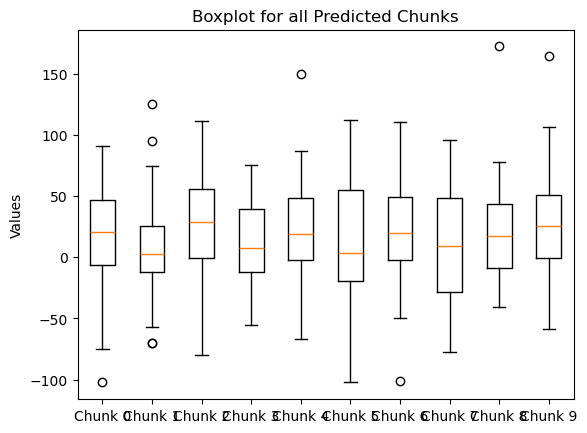

In [62]:
# Create boxplot
plt.boxplot(all_pred, labels=[f'Chunk {i}' for i in range(len(all_pred))])

# Add title
plt.title("Boxplot for all Predicted Chunks")
plt.ylabel("Values")

plt.show()

/tmp/ipykernel_422/817764619.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_coef, labels=[f'Chunk {i}' for i in range(len(all_pred))])


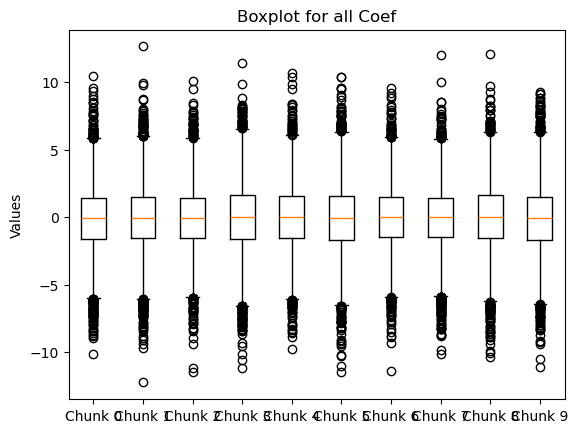

In [63]:
# Create boxplot
plt.boxplot(all_coef, labels=[f'Chunk {i}' for i in range(len(all_pred))])

# Add title
plt.title("Boxplot for all Coef")
plt.ylabel("Values")

plt.show()

<h1 style='color:red'>**Idea** use the outliers to find areas best for prediction</h1>

Model coefficients look too similar, I doubt anything would change if we average them.

In [64]:
all_pred_flat = np.array(all_pred).flatten()
all_test_flat = np.array(all_test).flatten()

y_test_binary = (all_test_flat > threshold).astype(int)
y_pred_binary = (all_pred_flat > threshold).astype(int)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 64 126]
 [ 57 113]]


In [65]:
tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print('Precision', precision)
print('Recall', recall)

Precision 0.47280334728033474
Recall 0.6647058823529411


# SGD Regressor

Trying another regression model that can be updated iteratively

In [66]:
chunks = [right_df.iloc[shuffled_indices[i * sample_size: (i + 1) * sample_size]] for i in range(num_samples)]
allX = []
allY = []

for i in range(len(chunks)):
    idx = np.append(np.array(left_df.index), np.array(chunks[i].index))
    matrix_chunk = matrices[idx]
    
    #getting top triangle of all matrices
    dataX = []
    for m in matrix_chunk:
        top_corner = np.triu(m, 1)
        just_data = top_corner[top_corner != 0]
        arr_data = just_data.flatten()
        dataX.append(arr_data)
    
    dataY = np.array(handedness.loc[idx]['Handedness'])

    allX.append(dataX)
    allY.append(dataY)

In [80]:
model = SGDRegressor(alpha=0.1, warm_start=True)
all_xtest = []
all_ytest = []
for i in range(len(allX)):
    dataX = allX[i]
    dataY = allY[i]
    X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2, random_state=42)
    model.fit(dataX, dataY)

    all_xtest.append(X_test)
    all_ytest.append(y_test)

In [68]:
all_xtest[0][0]

array([ 0.2090147 ,  0.32475903, -0.70536605, ...,  0.02162342,
        0.02779671,  0.03992359], shape=(4950,))

In [69]:
all_xtest = [mat for lst in all_xtest for mat in lst]
all_ytest = np.array(all_ytest).flatten()

y_pred = model.predict(all_xtest)

### Analysis

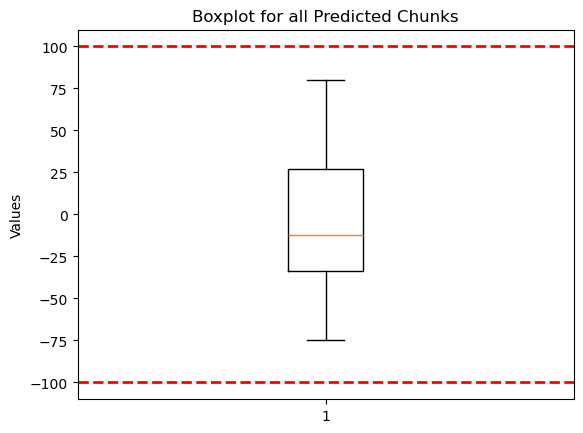

In [70]:
 # Create boxplot
plt.boxplot(y_pred)
plt.axhline(y=-100, color='r', linestyle='--', linewidth=2)
plt.axhline(y=100, color='r', linestyle='--', linewidth=2)


# Add title
plt.title("Boxplot for all Predicted Chunks")
plt.ylabel("Values")

plt.show()

In [71]:
y_test_binary = (y_pred > threshold).astype(int)
y_pred_binary = (all_ytest > threshold).astype(int)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[171  25]
 [  0 128]]


In [72]:
tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print('Precision', precision)
print('Recall', recall)

Precision 0.8366013071895425
Recall 1.0


In [73]:
data = model.coef_

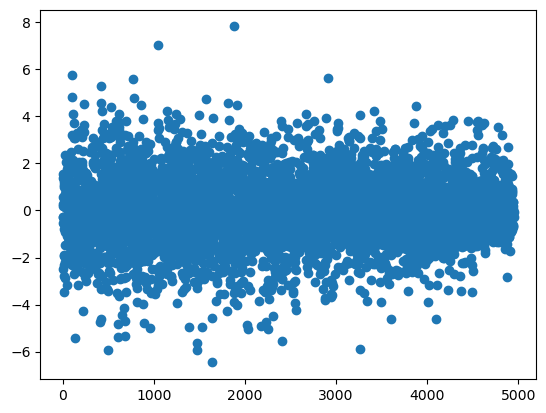

In [74]:
plt.scatter(x=range(len(model.coef_)), y=model.coef_)

(array([9.000e+00, 3.800e+01, 2.530e+02, 1.069e+03, 2.030e+03, 1.178e+03,
        3.150e+02, 5.200e+01, 4.000e+00, 2.000e+00]),
 array([-6.46212881, -5.0337229 , -3.60531698, -2.17691107, -0.74850515,
         0.67990076,  2.10830668,  3.53671259,  4.96511851,  6.39352443,
         7.82193034]),
 <BarContainer object of 10 artists>)

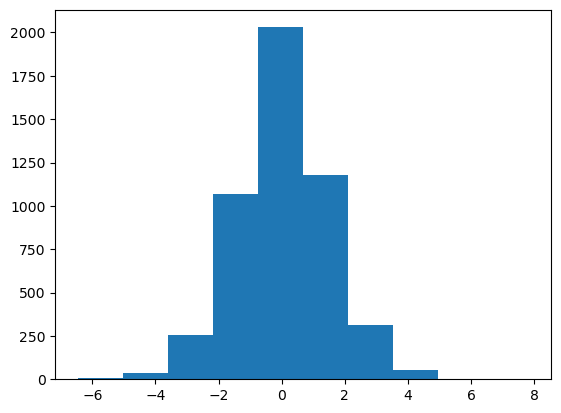

In [75]:
plt.hist(model.coef_)

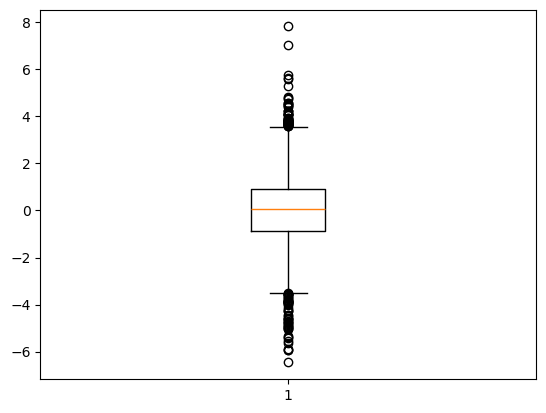

In [76]:
plt.boxplot(model.coef_)
plt.show()

In [77]:
# Calculate statistics
data = model.coef_
min_val = np.min(data)  # Minimum value
q1 = np.percentile(data, 25)  # First quartile (25th percentile)
median = np.median(data)  # Median (50th percentile)
q3 = np.percentile(data, 75)  # Third quartile (75th percentile)
max_val = np.max(data)  # Maximum value
iqr = q3 - q1  # Interquartile range (IQR)

# Print the statistics
print(f"Min: {min_val}")
print(f"Q1: {q1}")
print(f"Median: {median}")
print(f"Q3: {q3}")
print(f"Max: {max_val}")
print(f"IQR: {iqr}")

Min: -6.462128813452543
Q1: -0.8626240341978699
Median: 0.06290712584850784
Q3: 0.9083395986896273
Max: 7.821930341115847
IQR: 1.7709636328874971


In [78]:
coef_SGD = model.coef_
# Find values above the max
above_max = coef_SGD[coef_SGD > q3+(1.5) *iqr]

# Find values below the min
below_min = coef_SGD[coef_SGD < q1-(1.5)*iqr]

#number of regions above max and below min
len(np.hstack((above_max, below_min)))

110

## Select important features iteratively

In [ ]:
all_support = []
all_ranking = []
for i in range(len(allX)):
    dataX = allX[i]
    dataY = allY[i]
    X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2, random_state=42)
    selector = RFECV(model, step=1, cv=5)
    selector = selector.fit(X_train, y_train)
    all_support.append(selector.support_)
    all_ranking.append(selector.ranking_)

In [ ]:
sfs_support = []
for i in range(len(allX)):
    dataX = allX[i]
    dataY = allY[i]
    X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.2, random_state=42)
    model = SGDRegressor(alpha=0.1, warm_start=True)
    sfs = SequentialFeatureSelector(knn, n_features_to_select=100)
    sfs.fit()
    sfs_support.append(sfs.get_support())